# Importing Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,re,h5py
import time
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten,Conv2D,MaxPooling2D, Dropout,BatchNormalization,ZeroPadding2D,Concatenate,Input
from keras.models import Model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [ ]:
PATH = "/content/drive/MyDrive/minor_gans/chest_xray"
METRICS_PATH="/content/drive/MyDrive/minor_gans/output/densenet/"
MODEL_NAME="DenseNEt201"
print("PWD", PATH)

PWD /content/drive/MyDrive/minor_gans/chest_xray


# Define Metrics

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from drive

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [ ]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['NORMAL', 'PNEUMONIA']


In [ ]:
img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        img_data_list.append(x)


Loaded the images of dataset-NORMAL

Loaded the images of dataset-PNEUMONIA



In [ ]:
img_data = np.array(img_data_list)
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(5857, 1, 32, 32, 3)
(1, 5857, 32, 32, 3)
(5857, 32, 32, 3)


# Train and Test Data

In [ ]:
num_classes = 2
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:1584] = 0
labels[1584:] = 1
names = ['NORMAL', 'PNEUMONIA']

sample 5857


In [ ]:
from sklearn.utils import shuffle


In [ ]:
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [ ]:
input_shape = (32, 32, 3)
base_model = tf.keras.applications.DenseNet201(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

# Add a new classification head on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
model.summary()


74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 18,814,274
Trainable params: 492,290
Non-tr

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-10)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+'.csv', append=True, separator=';')
adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1,specificity,sensitivity])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
print(METRICS_PATH+MODEL_NAME+'.csv')

/content/drive/MyDrive/minor_gans/output/densenet/DenseNEt201.csv


# Model Training

### With Augumentation

In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:
def results():
  print('------------Training time is seconds:%s',time.time()-start_time)
  scores = model.evaluate(x_test, y_test, verbose=1)

  #history keys and values
  print(history.history.keys())
  print(history.history.values())

  #Metrics for testing
  print(scores)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  print('Test f1:',scores[2])
  print('Test sensitivity:',scores[3])
  print('Test specificity:',scores[4])
  print("Max Test accuracy", max(history.history['val_accuracy']))

  import matplotlib.pyplot as plt
  # summarize history for accuracy

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
  plt.show()

  # summarize history for loss

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
  plt.show()


In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Using real-time data augmentation.


<ipython-input-19-eb7f1dcb9614>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/100
293/293 [==============================] - 38s 61ms/step - loss: 0.4962 - accuracy: 0.7590 - f1: 0.7591 - specificity: 0.7591 - sensitivity: 0.7591 - val_loss: 0.3910 - val_accuracy: 0.8481 - val_f1: 0.8486 - val_specificity: 0.8486 - val_sensitivity: 0.8486 - lr: 6.0000e-05
Epoch 2/100
293/293 [==============================] - 9s 31ms/step - loss: 0.3709 - accuracy: 0.8314 - f1: 0.8314 - specificity: 0.8314 - sensitivity: 0.8314 - val_loss: 0.2995 - val_accuracy: 0.8882 - val_f1: 0.8868 - val_specificity: 0.8868 - val_sensitivity: 0.8868 - lr: 6.0000e-05
Epoch 3/100
293/293 [==============================] - 9s 30ms/step - loss: 0.3401 - accuracy: 0.8493 - f1: 0.8494 - specificity: 0.8494 - sensitivity: 0.8494 - val_loss: 0.2971 - val_accuracy: 0.8925 - val_f1: 0.8931 - val_specificity: 0.8931 - val_sensitivity: 0.8931 - lr: 6.0000e-05
Epoch 4/100
293/293 [==============================] - 10s 33ms/step - loss: 0.3152 - accuracy: 0.8670 - f1: 0.8670 - specificity: 0.8670 

In [ ]:
print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 1016.0029060840607
37/37 [==============================] - 1s 19ms/step - loss: 0.2564 - accuracy: 0.9053 - f1: 0.9052 - specificity: 0.9052 - sensitivity: 0.9052
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.49620917439460754, 0.3708656132221222, 0.3400728702545166, 0.31520307064056396, 0.3025420904159546, 0.29575562477111816, 0.29005715250968933, 0.28555241227149963, 0.2651804983615875, 0.27817222476005554, 0.26450687646865845, 0.26881885528564453, 0.2654583752155304, 0.25217434763908386, 0.2584010362625122, 0.24918442964553833, 0.2563830018043518, 0.2532280385494232, 0.2356414496898651, 0.24190135300159454, 0.2420361489057541, 0.24461369216442108, 0.24160505831241608, 0.2382747083902359, 0.2415662556886673, 0.23011496663093567, 0.2316007912158966, 0.22394490242004395, 0.2290833294391632, 0.2255861908197403, 0.238104417920112

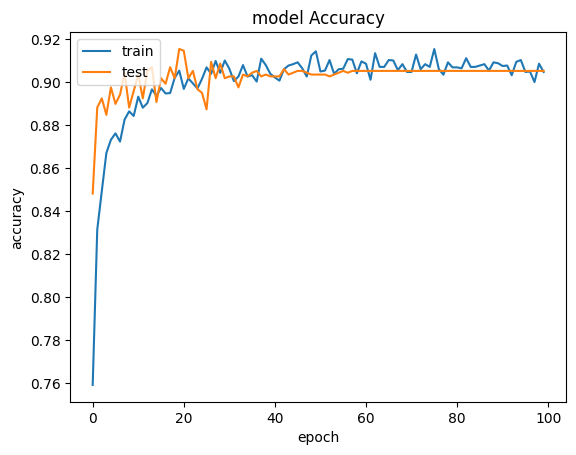

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

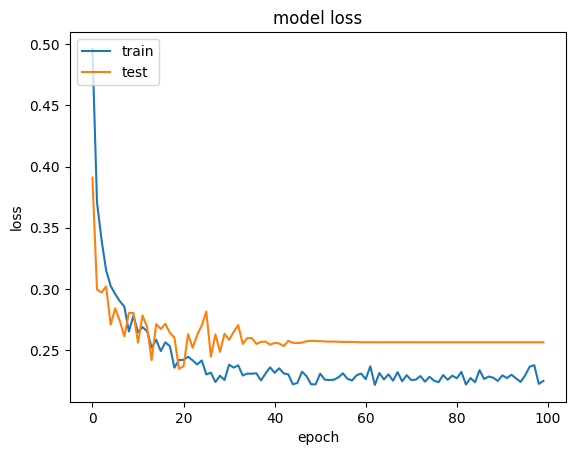

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()

#### Results with aug

### Without Augumentation

In [ ]:
MODEL_NAME="Densenet201_waug"

In [ ]:
input_shape = (32, 32, 3)
base_model = tf.keras.applications.DenseNet201(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

# Add a new classification head on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               491776    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 18,814,274
Trainable params: 492,290
Non-trainable params: 18,321,984
____________________________________

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-10)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+'.csv', append=True, separator=';')
adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1,specificity,sensitivity])


In [ ]:
batch_size = 16
data_augmentation = False
epochs = 100

In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Not using data augmentation.
Epoch 1/100
293/293 [==============================] - 23s 43ms/step - loss: 0.4219 - accuracy: 0.8077 - f1: 0.8077 - specificity: 0.8077 - sensitivity: 0.8077 - val_loss: 0.2881 - val_accuracy: 0.8831 - val_f1: 0.8818 - val_specificity: 0.8818 - val_sensitivity: 0.8818 - lr: 6.0000e-05
Epoch 2/100
293/293 [==============================] - 8s 28ms/step - loss: 0.2843 - accuracy: 0.8884 - f1: 0.8883 - specificity: 0.8883 - sensitivity: 0.8883 - val_loss: 0.2425 - val_accuracy: 0.9155 - val_f1: 0.9164 - val_specificity: 0.9164 - val_sensitivity: 0.9164 - lr: 6.0000e-05
Epoch 3/100
293/293 [==============================] - 7s 25ms/step - loss: 0.2507 - accuracy: 0.9048 - f1: 0.9049 - specificity: 0.9049 - sensitivity: 0.9049 - val_loss: 0.2285 - val_accuracy: 0.9172 - val_f1: 0.9181 - val_specificity: 0.9181 - val_sensitivity: 0.9181 - lr: 6.0000e-05
Epoch 4/100
293/293 [==============================] - 8s 29ms/step - loss: 0.2305 - accuracy: 0.9101 - f1: 0

In [ ]:
print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 872.7063162326813
37/37 [==============================] - 1s 23ms/step - loss: 0.1658 - accuracy: 0.9428 - f1: 0.9434 - specificity: 0.9434 - sensitivity: 0.9434
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.42194098234176636, 0.2842662036418915, 0.2507021725177765, 0.23045343160629272, 0.2185303270816803, 0.20709508657455444, 0.19764648377895355, 0.18958637118339539, 0.18238739669322968, 0.17810550332069397, 0.16871291399002075, 0.16368137300014496, 0.15971344709396362, 0.1568494737148285, 0.15091346204280853, 0.14651742577552795, 0.14481523633003235, 0.13852034509181976, 0.13147211074829102, 0.12750837206840515, 0.12923520803451538, 0.12347958981990814, 0.1216505691409111, 0.11570081859827042, 0.11298014968633652, 0.11092890053987503, 0.11052314937114716, 0.10735397785902023, 0.10556793957948685, 0.09995309263467789, 0.099436

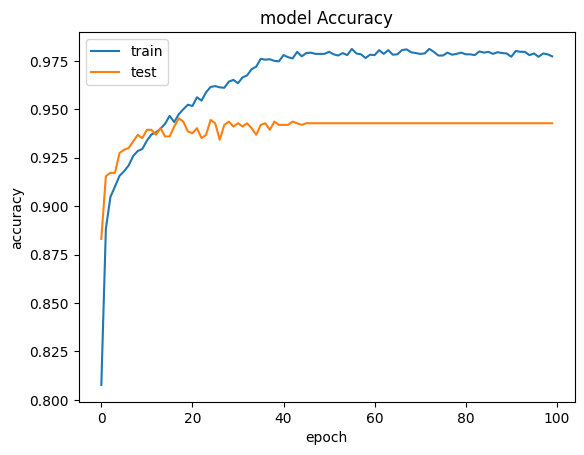

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

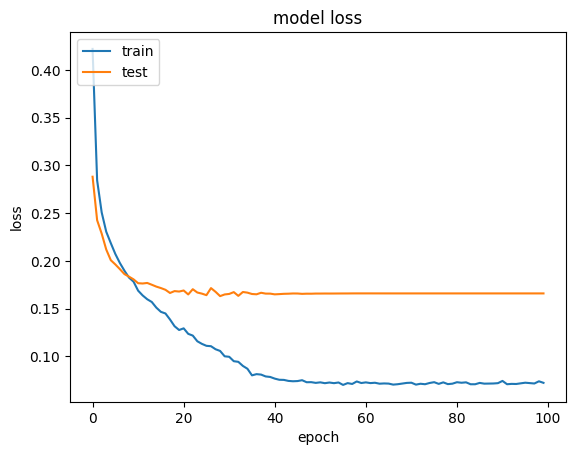

In [ ]:

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()